In [1]:
!pip -q install torch torchvision pillow scikit-learn webcolors open_clip_torch matplotlib kaggle einops timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00


In [2]:
import io, numpy as np, torch
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import webcolors
import open_clip

In [3]:
# Transforms simples; manter cores originais
tfm = transforms.Compose([
    transforms.ToTensor()  # [0,1]
])

stl_train = datasets.STL10(root="/content/data", split="train", download=True, transform=tfm)

len(stl_train), stl_train[0][0].shape  # -> (5000, torch.Size([3, 96, 96]))

100%|██████████| 2.64G/2.64G [01:59<00:00, 22.1MB/s]


(5000, torch.Size([3, 96, 96]))

In [4]:
import random

def sample_pixels_from_dataset(ds, n_images=200, per_image_pixels=2000, seed=42):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(ds), size=min(n_images, len(ds)), replace=False)
    pixels = []
    for i in idxs:
        img, _ = ds[i]  # C,H,W
        # converte para (H*W, 3) em 0..255
        arr = (img.permute(1,2,0).numpy() * 255).astype(np.uint8).reshape(-1, 3)
        sel = rng.choice(arr.shape[0], size=min(per_image_pixels, arr.shape[0]), replace=False)
        pixels.append(arr[sel])
    return np.concatenate(pixels, axis=0)

# Amostra rápida de pixels (cerca de 200 * 2000 = 400k pixels)
pixels = sample_pixels_from_dataset(stl_train, n_images=150, per_image_pixels=1500)

# Treina o KMeans "global" (codebook de cores)
K = 10
kmeans_global = KMeans(n_clusters=K, n_init=10, random_state=0)
kmeans_global.fit(pixels.astype(np.float32))


KMeans(n_clusters=10, n_init=10, random_state=0)

Text(0.5, 1.0, 'Elbow plot - escolha do k')

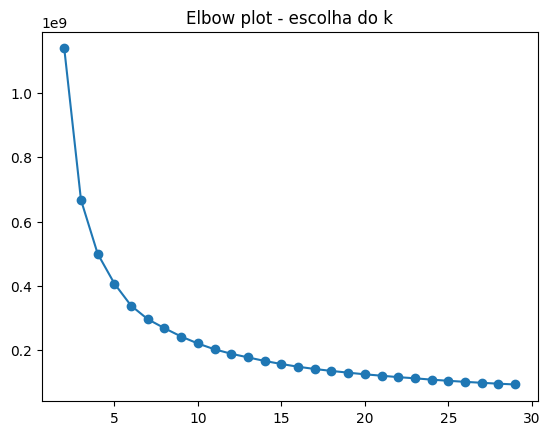

In [14]:
inertias = []
for k in range(2, 30):
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    km.fit(pixels)
    inertias.append(km.inertia_)
plt.plot(range(2,30), inertias, 'o-')
plt.title("Elbow plot - escolha do k")

In [5]:
import os, zipfile, shutil, json
os.makedirs('/root/.kaggle', exist_ok=True)

In [6]:
from google.colab import files
files.upload()
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download -d msambare/fer2013
with zipfile.ZipFile('fer2013.zip') as z: z.extractall('/content/fer2013')

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.66GB/s]


In [8]:
import os

CANDIDATES = [
    "/content/data/fer2013",
    "/content/data/fer2013/fer2013",
    "/content/fer2013",
    "/content/fer2013/fer2013",
]
DATA_ROOT = None
for r in CANDIDATES:
    if os.path.isdir(os.path.join(r, "train")):
        DATA_ROOT = r
        break

assert DATA_ROOT is not None, "Não achei a pasta 'train/'. Veja o conteúdo com !ls -R /content/data/fer2013"
print("DATA_ROOT:", DATA_ROOT)
print("Subpastas:", os.listdir(DATA_ROOT))


DATA_ROOT: /content/fer2013
Subpastas: ['test', 'train']


In [9]:
import os, random
import torch, open_clip
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
model = model.to(device).eval()

class ConvertRGB:  # evita problemas com grayscale
    def __call__(self, image):
        return image.convert('RGB')

tfm = transforms.Compose([ConvertRGB(), preprocess])

DATA_ROOT = "/content/fer2013"
train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=tfm)
test_ds  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=tfm)
print("Classes:", train_ds.classes)

def balanced_subset_indices(dataset, per_class=800, seed=42):
    rng = random.Random(seed)
    buckets = defaultdict(list)
    for idx, (_, y) in enumerate(dataset.samples):
        buckets[y].append(idx)
    for y in buckets: rng.shuffle(buckets[y])
    sel = []
    for y, arr in buckets.items():
        sel.extend(arr[:min(per_class, len(arr))])
    rng.shuffle(sel)
    return sel

train_idx = balanced_subset_indices(train_ds, per_class=800)
val_idx   = balanced_subset_indices(test_ds,  per_class=300)

train_sub = Subset(train_ds, train_idx)
val_sub   = Subset(test_ds,  val_idx)

train_ld = DataLoader(train_sub, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
val_ld   = DataLoader(val_sub,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# loader completo de teste (para métrica final)
test_ld  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
@torch.inference_mode()
def extract_feats(loader):
    feats, labs = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        f = model.encode_image(x)
        f = f / f.norm(dim=-1, keepdim=True)  # normaliza
        feats.append(f.float().cpu())
        labs.append(torch.as_tensor(y))
    return torch.cat(feats), torch.cat(labs)

Xtr, ytr = extract_feats(train_ld)
Xva, yva = extract_feats(val_ld)
Xte, yte = extract_feats(test_ld)
Xtr.shape, Xva.shape, Xte.shape


(torch.Size([5236, 512]), torch.Size([1911, 512]), torch.Size([7178, 512]))

In [13]:
emotions = ["angry","disgust","fear","happy","sad","surprise","neutral"]
tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer([f"a face showing {e}" for e in emotions]).to(device)

val_ds_zz = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"), transform=lambda im: preprocess(im.convert("RGB")))
val_ld_zz = DataLoader(val_ds_zz, batch_size=64, shuffle=False, num_workers=2)

correct = total = 0
with torch.inference_mode():
    text_feat = model.encode_text(text); text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    for x,y in val_ld_zz:
        x = x.to(device)
        img_feat = model.encode_image(x); img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        logits = 100. * img_feat @ text_feat.T
        pred = logits.argmax(1).cpu()
        correct += (pred==y).sum().item()
        total   += y.numel()
print("Zero-shot CLIP (val) acc:", correct/total)


Zero-shot CLIP (val) acc: 0.34912231819448314


In [16]:
from torch import nn

mlp = nn.Sequential(
    nn.Linear(Xtr.shape[1], 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(train_ds.classes))
).to(device)

opt = torch.optim.AdamW(mlp.parameters(), lr=3e-4, weight_decay=1e-2)
ce  = nn.CrossEntropyLoss()

def run_epoch(X, y, train=True, bs=256):
    mlp.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    idx = torch.randperm(len(X)) if train else torch.arange(len(X))
    for i in range(0, len(X), bs):
        b = idx[i:i+bs]
        xb, yb = X[b].to(device), y[b].to(device)
        if train: opt.zero_grad()
        logits = mlp(xb)
        loss = ce(logits, yb)
        if train:
            loss.backward()
            opt.step()
        loss_sum += loss.item()*len(b)
        correct += (logits.argmax(1)==yb).sum().item()
        total += len(b)
    return loss_sum/total, correct/total

best_acc, best_state = 0.0, None
for epoch in range(50):  # aumente para 10–15 se quiser
    tr_loss, tr_acc = run_epoch(Xtr, ytr, train=True)
    va_loss, va_acc = run_epoch(Xva, yva, train=False)
    if va_acc > best_acc:
        best_acc, best_state = va_acc, mlp.state_dict()
    print(f"epoch {epoch}: train_acc={tr_acc:.3f}  val_acc={va_acc:.3f}")

mlp.load_state_dict(best_state)
print(f"Melhor val_acc: {best_acc:.3f}")



epoch 0: train_acc=0.221  val_acc=0.334
epoch 1: train_acc=0.386  val_acc=0.435
epoch 2: train_acc=0.443  val_acc=0.468
epoch 3: train_acc=0.457  val_acc=0.468
epoch 4: train_acc=0.462  val_acc=0.476
epoch 5: train_acc=0.477  val_acc=0.484
epoch 6: train_acc=0.480  val_acc=0.486
epoch 7: train_acc=0.480  val_acc=0.495
epoch 8: train_acc=0.494  val_acc=0.502
epoch 9: train_acc=0.501  val_acc=0.504
epoch 10: train_acc=0.504  val_acc=0.509
epoch 11: train_acc=0.512  val_acc=0.512
epoch 12: train_acc=0.517  val_acc=0.518
epoch 13: train_acc=0.526  val_acc=0.526
epoch 14: train_acc=0.532  val_acc=0.527
epoch 15: train_acc=0.545  val_acc=0.538
epoch 16: train_acc=0.552  val_acc=0.540
epoch 17: train_acc=0.550  val_acc=0.549
epoch 18: train_acc=0.560  val_acc=0.553
epoch 19: train_acc=0.567  val_acc=0.555
epoch 20: train_acc=0.571  val_acc=0.560
epoch 21: train_acc=0.574  val_acc=0.564
epoch 22: train_acc=0.582  val_acc=0.569
epoch 23: train_acc=0.580  val_acc=0.571
epoch 24: train_acc=0.583 

In [25]:
# salvando modelo
torch.save({
    'classes': train_ds.classes,
    'dim': Xtr.shape[1],
    'state_dict': mlp.state_dict()
}, '/content/models/clip_mlp_emotion.pt')

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

def eval_logits(X, y, model_torch, device='cuda', bs=256):
    """
    X: torch.Tensor [N, D]  (features CLIP normalizadas)
    y: torch.Tensor [N]     (rótulos)
    model_torch: seu MLP treinado
    """
    model_torch.eval()
    preds = []
    with torch.inference_mode():
        for i in range(0, len(X), bs):
            xb = X[i:i+bs].to(device)
            logits = model_torch(xb)
            preds.append(logits.argmax(1).cpu().numpy())
    preds = np.concatenate(preds)
    y_np = y.cpu().numpy()
    acc = accuracy_score(y_np, preds)
    return acc, preds

In [20]:
test_acc, test_pred = eval_logits(Xte, yte, mlp, device)
print("TEST acc:", round(test_acc, 4))
print(classification_report(yte.cpu().numpy(), test_pred, target_names=train_ds.classes, digits=3))
print(confusion_matrix(yte.cpu().numpy(), test_pred))

TEST acc: 0.6194
              precision    recall  f1-score   support

       angry      0.519     0.548     0.533       958
     disgust      0.195     0.468     0.275       111
        fear      0.402     0.243     0.303      1024
       happy      0.878     0.859     0.868      1774
     neutral      0.598     0.662     0.628      1233
         sad      0.525     0.506     0.516      1247
    surprise      0.663     0.782     0.718       831

    accuracy                          0.619      7178
   macro avg      0.540     0.581     0.549      7178
weighted avg      0.617     0.619     0.614      7178

[[ 525   76   73   36   94  109   45]
 [  35   52    6    4    5    5    4]
 [ 158   57  249   36  115  233  176]
 [  42    9   13 1523   93   26   68]
 [  62   17   74   66  816  182   16]
 [ 153   50  134   36  222  631   21]
 [  37    6   71   33   19   15  650]]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

def extract_palette_kmeans(
    img,
    k=6,
    use_global=True,
    kmeans_global=None,
    sample_max=120_000,
    random_state=42,
):
    """
    Extrai paleta de cores (k) de uma imagem via KMeans/MiniBatchKMeans.
    Se use_global=True e kmeans_global compatível for passado, usa .predict
    para rotular pixels sem refazer o fit.

    Retorna:
        palette: np.ndarray (k, 3) em uint8, ordenada por frequência desc
        weights: np.ndarray (k,) somando 1.0, mesma ordem da palette
    """
    # garante RGB e vira (H*W, 3)
    arr = np.asarray(img.convert("RGB"), dtype=np.uint8)
    flat = arr.reshape(-1, 3)

    # amostragem para acelerar o fit
    n = len(flat)
    if n > sample_max:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(n, size=sample_max, replace=False)
        sample = flat[idx]
    else:
        sample = flat

    centers = None
    if use_global and isinstance(kmeans_global, MiniBatchKMeans) and getattr(kmeans_global, "n_clusters", None) == k:
        # usa modelo global para obter labels/centros
        labels = kmeans_global.predict(flat)
        centers = kmeans_global.cluster_centers_
    else:
        # treina rapidamente num minibatch
        km = MiniBatchKMeans(
            n_clusters=k,
            random_state=random_state,
            batch_size=4096,
            n_init=3,
            max_no_improvement=20,
            reassignment_ratio=0.005,
        )
        km.fit(sample)
        centers = km.cluster_centers_
        labels = km.predict(flat)

    # conta frequência por cluster
    counts = np.bincount(labels, minlength=k).astype(np.float64)
    total = counts.sum()
    # evita divisão por zero
    total = max(total, 1.0)
    weights = counts / total

    # ordena por frequência decrescente
    order = np.argsort(-weights)
    weights = weights[order]
    centers = centers[order]

    # garante uint8 0..255
    palette = np.clip(np.rint(centers), 0, 255).astype(np.uint8)
    return palette, weights

def show_palette(palette, weights, title=None):
    """
    Mostra barras proporcionais às weights para cada cor na palette.
    palette: (k,3) uint8 | weights: (k,)
    """
    k = len(palette)
    fig, ax = plt.subplots(figsize=(max(4, k), 1.4))
    x0 = 0.0
    for i in range(k):
        w = float(weights[i])
        ax.barh(
            [0],
            width=w,
            left=x0,
            height=0.8,
            edgecolor="none",
            align="center",
            # sem cores explícitas definidas pelo guideline? Aqui é útil:
            color=[tuple(palette[i] / 255.0)]
        )
        x0 += w

    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xticks([])
    if title:
        ax.set_title(title)
    plt.show()

In [26]:
import torch, open_clip, torch.nn.functional as F
from PIL import Image
from pathlib import Path

CKPT = '/content/models/clip_mlp_emotion.pt'   # caminho do modelo
IMG  = '/content/images (3).jpeg'             #  imagem
MODEL_NAME, PRETRAINED = 'ViT-B-32', 'openai'
TTA = True                                        # Test-Time Augmentation (flip horizontal)

# --- modelo CLIP só como extrator de features ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
model = model.to(device).eval()

# --- carrega o HEAD MLP ---
ckpt = torch.load(CKPT, map_location=device)
classes = ckpt['classes']          # nomes das classes
feat_dim = ckpt['dim']             # dimensão de embedding usada no treino
mlp = torch.nn.Sequential(
    torch.nn.Linear(feat_dim, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, len(classes))
).to(device).eval()
mlp.load_state_dict(ckpt['state_dict'])

def clip_feature(pil_img: Image.Image):
    x = preprocess(pil_img.convert("RGB")).unsqueeze(0).to(device)
    f = model.encode_image(x)
    return f / f.norm(dim=-1, keepdim=True)

@torch.inference_mode()
def predict_head(pil_img: Image.Image, topk=3, tta=TTA):
    feats = [clip_feature(pil_img)]
    if tta:
        feats.append(clip_feature(pil_img.transpose(Image.FLIP_LEFT_RIGHT)))
    f = torch.stack(feats).mean(0)                # média das features (TTA)
    logits = mlp(f)
    probs = F.softmax(logits, dim=-1).squeeze(0)
    k = min(topk, len(classes))
    topv, topi = torch.topk(probs, k)
    return [(classes[i], float(topv[j])) for j, i in enumerate(topi)]


/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Top-3 (head MLP): [('happy', 0.631120502948761), ('surprise', 0.29244449734687805), ('fear', 0.04364221543073654)]


Saving images (3).jpeg to images (3) (2).jpeg


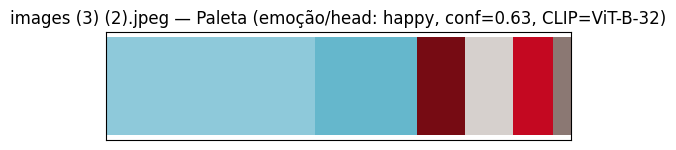

In [27]:
# deps
import io, sys, os
from PIL import Image, ImageOps
from google.colab import files

import torch
import torch.nn.functional as F
try:
    import open_clip
except ImportError:
    !pip -q install open_clip_torch
    import open_clip

# ====== NOVO: carregar CLIP (apenas extrator) + HEAD MLP ======
CKPT = '/content/models/clip_mlp_emotion.pt'
TTA  = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = torch.load(CKPT, map_location=device)
classes = ckpt['classes']
feat_dim = ckpt['dim']

# escolhe automaticamente o backbone compatível com o dim salvo no ckpt
def _load_clip_by_dim(target_dim: int):
    CANDIDATES = [
        ('ViT-B-32', 'openai'),
        ('ViT-L-14', 'openai'),
        ('ViT-B-16', 'openai'),
        ('ViT-L-14-336', 'openai'),
    ]
    for name, pretrained in CANDIDATES:
        m, _, pp = open_clip.create_model_and_transforms(name, pretrained=pretrained)
        if getattr(m.visual, 'output_dim', None) == target_dim:
            return m.to(device).eval(), pp, name
    # fallback: usa B-32 e torce para coincidir
    m, _, pp = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    if getattr(m.visual, 'output_dim', None) != target_dim:
        raise ValueError(f"Não achei backbone CLIP com output_dim={target_dim}. "
                         f"Tente re-extrair/treinar ou ajuste manualmente o MODEL_NAME.")
    return m.to(device).eval(), pp, 'ViT-B-32'

clip_model, preprocess, MODEL_NAME = _load_clip_by_dim(feat_dim)

# constrói o head MLP igual ao treino
mlp = torch.nn.Sequential(
    torch.nn.Linear(feat_dim, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, len(classes))
).to(device).eval()
mlp.load_state_dict(ckpt['state_dict'])

def _clip_feature(pil_img: Image.Image):
    x = preprocess(pil_img.convert("RGB")).unsqueeze(0).to(device)
    f = clip_model.encode_image(x)
    return f / f.norm(dim=-1, keepdim=True)

@torch.inference_mode()
def predict_head_top(img: Image.Image, topk=3, tta=TTA):
    feats = [_clip_feature(img)]
    if tta:
        feats.append(_clip_feature(img.transpose(Image.FLIP_LEFT_RIGHT)))
    f = torch.stack(feats).mean(0)                 # [1, D]
    logits = mlp(f)
    probs = F.softmax(logits, dim=-1).squeeze(0)   # [C]
    k = min(topk, len(classes))
    topv, topi = torch.topk(probs, k)
    top = [(classes[int(i)], float(v)) for v, i in zip(topv.tolist(), topi.tolist())]
    return top[0][0], top[0][1], top  # (label_top1, conf_top1, lista_topk)

# util p/ abrir imagem com segurança
def _open_image_safely(raw_bytes):
    img = Image.open(io.BytesIO(raw_bytes))
    img = ImageOps.exif_transpose(img)          # corrige orientação EXIF
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")                 # RGBA/CMYK/etc → RGB
    elif img.mode == "L":
        img = img.convert("RGB")                 # grayscale → RGB
    return img

# fallback caso kmeans_global não exista
try:
    _ = kmeans_global
except NameError:
    kmeans_global = None

# ==== upload + loop principal ====
uploads = files.upload()  # selecione 1+ imagens
if not uploads:
    raise RuntimeError("Nenhum arquivo selecionado.")

for name, raw in uploads.items():
    try:
        img = _open_image_safely(raw)

        # extrai paleta (k=6 por padrão)
        palette, weights = extract_palette_kmeans(
            img, k=6, use_global=True, kmeans_global=kmeans_global
        )

        emo, conf, topk = predict_head_top(img, topk=3, tta=TTA)

        # exibe paleta com título descritivo
        show_palette(
            palette, weights,
            title=f"{name} — Paleta (emoção/head: {emo}, conf={conf:.2f}, CLIP={MODEL_NAME})"
        )

    except Exception as e:
        print(f"[ERRO] {name}: {e}", file=sys.stderr)
